In [2]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pysam

BASEDIR = "/data1/shahs3/users/sunge/cnv_simulator"
DATADIR = f"{BASEDIR}/data"

## Plot simulated ground-truth CNV profiles

In [35]:
# Load CNV profile data
test_name = "minitest_c3_6"
cnv_profile_df = pd.read_csv(f"{DATADIR}/small_cnv_profiles/{test_name}_cnv_profile.tsv", sep="\t")

# Set figure directory and make if it doesn't exist
FIGDIR = f"{BASEDIR}/figs/{test_name}"
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)

cnv_profile_df.head()

,clone,chr,start,end,copy_number,state,size,cell_barcode,cell_group
0,0,1,0,45302619,0,2,45302619.0,"A108753B-R48-C70,128725A-R54-C25,130424A-R60-C...","10,9,2,2,6,5,10,8,8,1,9,4,10,3,8,9,2,3,4,2,1,1..."
1,0,1,45302619,60209592,4,6,9924696.0,"128655A-R19-C58,128673A-R19-C45,128673A-R24-C4...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
2,0,1,45302619,55227315,4,6,9924696.0,"128655A-R19-C58,128673A-R14-C52,128673A-R19-C4...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
3,0,1,55227315,112885486,0,2,57658171.0,"A108753B-R48-C70,128725A-R54-C25,130424A-R60-C...","10,9,2,2,6,5,10,8,8,1,9,4,10,3,8,9,2,3,4,2,1,1..."
4,0,1,112885486,114974512,4,6,2089026.0,"110675-R27-C23,128655A-R19-C58,128673A-R19-C45...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."


In [ ]:
copynumber_colors = {
    "0": "#2C78B2",  # Dark blue
    "1": "#94C4DB",  # Light blue
    "2": "#C5C5C5",  # Gray
    "3": "#FCC484",  # Light orange
    "4": "#FA8154",  # Orange
    "5": "#DD4031",  # Red-orange
    "6": "#A9000D",  # Dark red
    "7": "#8C033A",  # Burgundy
    "8": "#6A1B9A",  # Medium purple
    "9": "#4A148C",  # Dark purple
    "10": "#38006B",  # Very dark purple
    "11": "#2E0057",  # Deep purple
    "12": "#240043",  # Almost black purple
    "13": "#1A002F",  # Darkest purple
    "14": "#12001C",  # Near-black purple
}

def plot_true_cnv(cnv_profile_df, save = True):
    num_clones = len(cnv_profile_df["clone"].unique())

    chr_lengths = cnv_profile_df.groupby("chr")["end"].max().sort_index()
    chr_offsets = chr_lengths.cumsum().shift(fill_value = 0).to_dict()
    chr_labels = {pos: chr for chr, pos in chr_offsets.items()}

    cnv_profile_df["genome_start"] = cnv_profile_df.apply(
        lambda row: row["start"] + chr_offsets[row["chr"]], axis=1)
    cnv_profile_df["genome_end"] = cnv_profile_df.apply(
        lambda row: row["end"] + chr_offsets[row["chr"]], axis=1)

    fig, ax = plt.subplots(nrows = len(cnv_profile_df["clone"].unique()),
                        ncols = 1,
                        figsize = (10, 2 * num_clones))

    for i, clone in enumerate(cnv_profile_df["clone"].unique()):
        clone_df = cnv_profile_df[cnv_profile_df["clone"] == clone]
        for _, row in clone_df.iterrows():
            ax[i].plot(
                [row["genome_start"], row["genome_end"]],
                [row["copy_number"], row["copy_number"]],
                color = copynumber_colors[str(row["state"])],
                alpha=0.7,
            )
        for offset in chr_offsets.values():
            ax[i].axvline(offset, color = "grey", linestyle = "--", linewidth = 0.5)

        ax[i].set_xticks(
            ticks = list(chr_offsets.values()),
            labels = list(chr_labels.values()),
            ha = "center"
        )

        ax[i].set_ylabel("Copy number")
        ax[i].set_title(f"Clone {clone} ()")

    plt.tight_layout()
    plt.show()

    if save:
        fig.savefig(f"{FIGDIR}/true_cnv_profile.png", dpi = 300, bbox_inches = "tight")
        print(f"Saved figure to {FIGDIR}/true_cnv_profile.png")



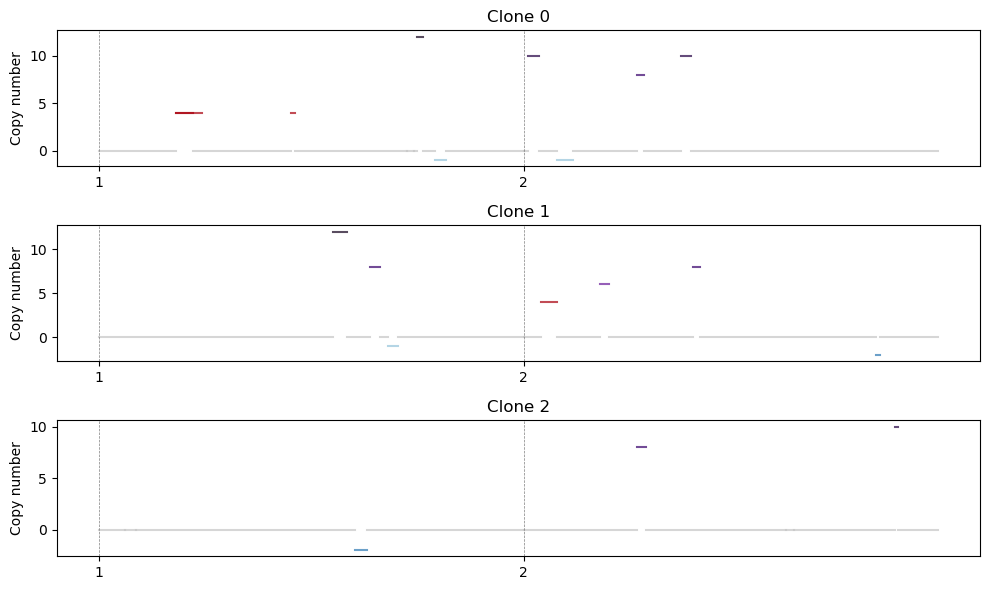

Saved figure to /data1/shahs3/users/sunge/cnv_simulator/figs/minitest_c3_6/true_cnv_profile.png


In [39]:
plot_true_cnv(cnv_profile_df, save = True)

In [41]:
bam_file_path = f"{DATADIR}/normal_cell_bams/group_0_merged.bam"

bamfile = pysam.AlignmentFile(bam_file_path, "rb")
chrom = "1"
start = 0
end = bamfile.get_reference_length(chrom)
bin_size = 100000

depths = []
for bin_start in range(start, end, bin_size):
    bin_end = min(bin_start + bin_size, end)
    count = bamfile.count(chrom, bin_start, bin_end)
    depths.append(count)

positions = np.arange(start, end, bin_size)
plt.plot(positions, depths)
plt.xlabel("Genomic position (bp)")
plt.ylabel("Read depth")
plt.title(f"{chrom} Read Depth")
plt.show()


KeyboardInterrupt: 